In [1]:
#!pip install yellowbrick
#!pip install kmodes

In [2]:
import pandas as pd
import numpy as np
import missingno as msno
import os
from datetime import timedelta
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
%matplotlib inline

In [3]:
os.getcwd()
os.chdir('C:\\Users\\IMEN\\Documents\\openclassroom\\formation openclassrooms\\projet5')

In [4]:
def felbow_kprototypes(k_rng,data,index_categ_feat):
    #Elbow technique
    cost = [] 
    for cluster in k_rng: 
        print('{cluster}\.cluster start'.format(cluster=cluster))
        kproto = KPrototypes(n_clusters = cluster, init='Huang',n_jobs=-1,n_init=10,verbose=1)
        kproto.fit(data, categorical=[index_categ_feat])
        cost.append(kproto.cost_)
      
    plt.plot(k_rng,cost)
    plt.xlabel('Number of clusters')
    plt.ylabel('Cost')

In [5]:
def felbow(k_rng,data):
    #Elbow technique
    wcss = [] 
    for i in k_rng: 
        model = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
        model.fit(data) 
        wcss.append(model.inertia_)
    plt.plot(k_rng,wcss)
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')

In [6]:
def fsilhouette(k_rng,data):
    #Silhouette technique
    sse_ = []
    for k in k_rng:
        kmeans = KMeans(n_clusters=k,init = 'k-means++', random_state = 42).fit(data)
        sse_.append([k, silhouette_score(data, kmeans.labels_)])
    plt.plot(pd.DataFrame(sse_)[0], pd.DataFrame(sse_)[1]);

In [7]:
def mean_clus_feat(df,group,feat):
    df_mean=pd.DataFrame(df.groupby(group)[feat].mean()).rename(columns={feat:feat+'_mean'})
    return df_mean

In [8]:
def fnb_customper_cluster(df):
    customer_per_cluster=pd.DataFrame(df.groupby('ClusterID')['CustomerID'].count())\
                .rename(columns={'CustomerID':'nb_customers'}).reset_index()
    return(customer_per_cluster)

### 1.Description des données

In [9]:
df_cmd=pd.read_csv('commandes_dataset.csv')
df_geo=pd.read_csv('geolocalisation_dataset.csv')


In [10]:
df_cmd.shape

(110845, 18)

In [11]:
df_cmd.columns

Index(['customer_id', 'customer_unique_id', 'customer_city', 'customer_state',
       'order_id', 'order_status', 'order_purchase_timestamp', 'order_item_id',
       'product_id', 'seller_id', 'price', 'payment_type', 'review_id',
       'review_score', 'product_category_name', 'seller_zip_code_prefix',
       'seller_city', 'seller_state'],
      dtype='object')

In [12]:
df_cmd.duplicated().sum()

0

In [13]:
df_cmd_initial=df_cmd.copy()

In [14]:
df_cmd['customer_unique_id'].nunique()

91478

### 2.Feature engineering

#### Fréquence : combien de fois chaque   client a-t-il effectué un achat ?

In [15]:
#nbre de commandes par client
nb_order_per_customer=pd.DataFrame(df_cmd.groupby('customer_unique_id')['customer_id'].count())\
.rename(columns={'customer_id':'frequency'}).reset_index()
nb_order_per_customer
freq=nb_order_per_customer
freq.shape
#df_cmd['frequency']=nb_order_per_customer['frequency']
#msno.bar(df_cmd)

(91478, 2)

#### Récence d'un client : à quel moment un client a effectué un dernier achat?

In [16]:
#Ici on détermine à quel moment un client a effectué un dernier achat
# convertir la date d'achat en format datetime 
df_cmd['order_purchase_timestamp']= pd.to_datetime(df_cmd['order_purchase_timestamp'])
# la date NOW à un jour après le dernier achat. 
NOW = df_cmd['order_purchase_timestamp'].max() + timedelta(days=1)
rec=pd.DataFrame(df_cmd.groupby('customer_unique_id')['order_purchase_timestamp'].max())\
.rename(columns={'order_purchase_timestamp':'last_purshase_date'}).reset_index()

freq_rec=pd.merge(freq,rec,on='customer_unique_id')
freq_rec


,customer_unique_id,frequency,last_purshase_date
0,0000366f3b9a7992bf8c76cfdf3221e2,1,2018-05-10 10:56:27
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,2018-05-07 11:11:27
2,0000f46a3911fa3c0805444483337064,1,2017-03-10 21:05:03
3,0000f6ccb0745a6a4b88665a16c9f078,1,2017-10-12 20:29:41
4,0004aac84e0df4da2b147fca70cf8255,1,2017-11-14 19:45:42
...,...,...,...
91473,fffcf5a5ff07b0908bd4e2dbc735a684,2,2017-06-08 21:00:36
91474,fffea47cd6d3cc0a88bd621562a9d061,1,2017-12-10 20:07:56
91475,ffff371b4d645b6ecea244b27531430a,1,2017-02-07 15:49:16
91476,ffff5962728ec6157033ef9805bacc48,1,2018-05-02 15:17:41



#### Montant

In [17]:
amount=pd.DataFrame(df_cmd.groupby('customer_unique_id')['price'].sum())\
.rename(columns={'price':'total_price'}).reset_index()
amount.shape

(91478, 2)

In [18]:
freq_rec_m=pd.merge(freq_rec,amount,on='customer_unique_id',how='inner')

freq_rec_m.shape

(91478, 4)

In [19]:
freq_rec_m.head()

,customer_unique_id,frequency,last_purshase_date,total_price
0,0000366f3b9a7992bf8c76cfdf3221e2,1,2018-05-10 10:56:27,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,2018-05-07 11:11:27,18.90
2,0000f46a3911fa3c0805444483337064,1,2017-03-10 21:05:03,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,1,2017-10-12 20:29:41,25.99
4,0004aac84e0df4da2b147fca70cf8255,1,2017-11-14 19:45:42,180.00


In [20]:
freq_rec_m['DaysSinceOrder'] = freq_rec_m['last_purshase_date'].apply(lambda x: (NOW - x).days)
freq_rec_m.head()

,customer_unique_id,frequency,last_purshase_date,total_price,DaysSinceOrder
0,0000366f3b9a7992bf8c76cfdf3221e2,1,2018-05-10 10:56:27,129.90,112
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,2018-05-07 11:11:27,18.90,115
2,0000f46a3911fa3c0805444483337064,1,2017-03-10 21:05:03,69.00,537
3,0000f6ccb0745a6a4b88665a16c9f078,1,2017-10-12 20:29:41,25.99,321
4,0004aac84e0df4da2b147fca70cf8255,1,2017-11-14 19:45:42,180.00,288


In [21]:
RFM=freq_rec_m[['customer_unique_id','frequency','DaysSinceOrder','total_price']].rename(columns={'frequency':'Frequency','DaysSinceOrder':'Recency','total_price':'Monetary'})

RFM

,customer_unique_id,Frequency,Recency,Monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,1,112,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,115,18.90
2,0000f46a3911fa3c0805444483337064,1,537,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,1,321,25.99
4,0004aac84e0df4da2b147fca70cf8255,1,288,180.00
...,...,...,...,...
91473,fffcf5a5ff07b0908bd4e2dbc735a684,2,447,1570.00
91474,fffea47cd6d3cc0a88bd621562a9d061,1,262,64.89
91475,ffff371b4d645b6ecea244b27531430a,1,568,89.90
91476,ffff5962728ec6157033ef9805bacc48,1,119,115.00


In [22]:
#plt.boxplot(RFM.Monetary)

In [23]:
RFM[["Recency", "Frequency", "Monetary"]].agg(["mean"])

,Recency,Frequency,Monetary
mean,237.047662,1.211712,144.949038


In [24]:
RFM.describe()

,Frequency,Recency,Monetary
count,91478.000000,91478.000000,91478.000000
mean,1.211712,237.047662,144.949038
std,0.679484,152.560470,220.997009
min,1.000000,1.000000,0.850000
25%,1.000000,114.000000,48.900000
50%,1.000000,218.000000,89.900000
75%,1.000000,345.000000,159.000000
max,24.000000,695.000000,13440.000000


**Observations**<br>
-La moyenne de la récnce est ~237j <br>
-en moyenne un client achète un article 1 fois(1.2)<br>
-et dépensant un prix unitaire moyen de 144.94 (unié de prix).


AttributeError: module 'seaborn' has no attribute 'hist'

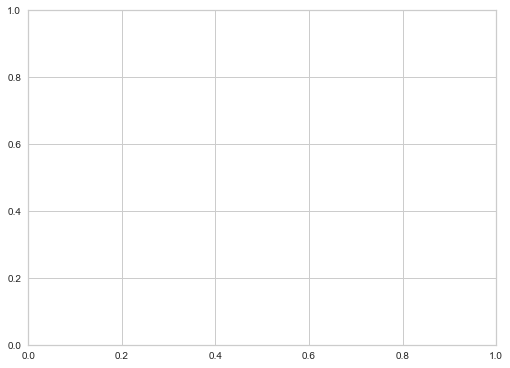

In [36]:
#Visualizing the Recency, Frequency and Monetary distributions.
i = 0
fig = plt.figure(constrained_layout = True,figsize = (20,5))
gs = GridSpec(1, 3, figure=fig)    

col = ['red','blue','green']
for var in list(RFM.columns[1:4]):
    plt.subplot(gs[0,i])
    #sns.histplot(RFM[var],color= col[i],kde=True,bins=20)
    sns.hist(RFM[var],color= col[i],kde=True,bins=20)
    plt.title('Skewness ' + ': ' + round(RFM[var].skew(),2).astype(str))
    i= i+1

**Observations**<br>
les données relatives à la fréquence et au pouvoir d'achat sont relativement asymétriques

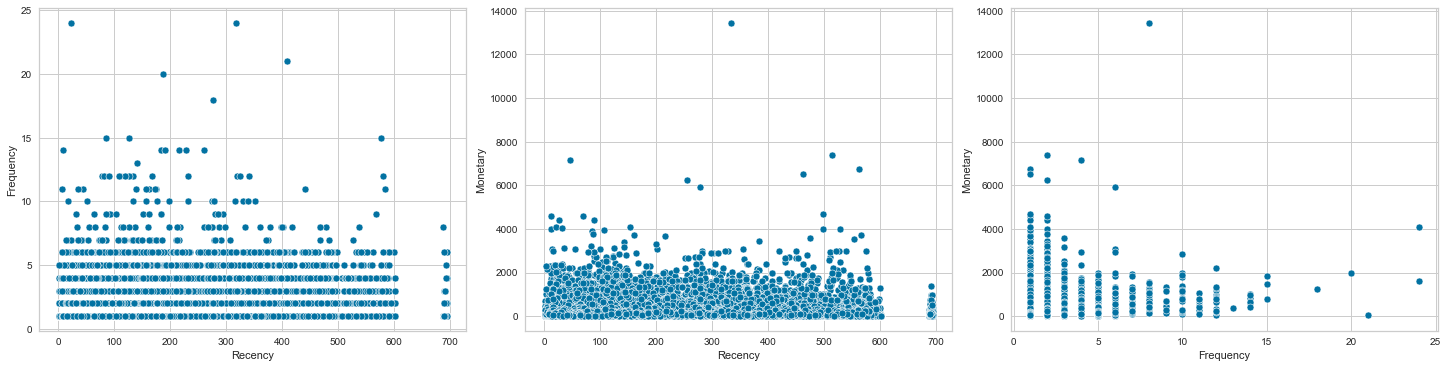

In [26]:


fig = plt.figure(constrained_layout = True,figsize = (20,5))
gs = GridSpec(1, 3, figure=fig) 
#"Recency", "Frequency", "Monetary"
lists=[["Recency", "Frequency"],["Recency","Monetary"],["Frequency","Monetary"]]
i=0

for c in lists:
    
    plt.subplot(gs[0,i])
    sns.scatterplot(data=RFM,x=c[0],y=c[1])    
    i= i+1




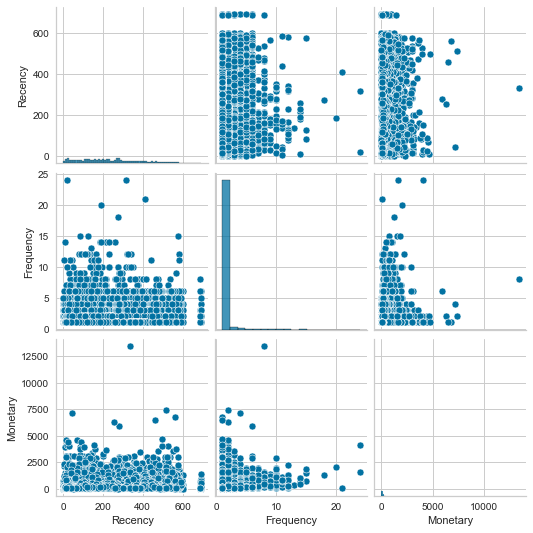

In [27]:
RFM_data = RFM[["Recency", "Frequency", "Monetary"]]

sns.pairplot(RFM_data)

**Observations**<br>

In [28]:
RFM.to_csv('df_rfm.csv',index=False)


In [29]:
RFM.columns

Index(['customer_unique_id', 'Frequency', 'Recency', 'Monetary'], dtype='object')